In [1]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import PrioritisedReplayBuffer
from fab import Trainer, PrioritisedBufferTrainer
from fab.utils.plotting import plot_contours, plot_marginal_pair
from experiments.make_flow import make_wrapped_normflow_realnvp
import importlib 
import models.ddpm
import models.mlp
importlib.reload(models.ddpm)
importlib.reload(models.mlp)
from models.ddpm import GaussianDiffusion, TMLP
from models.mlp import MyMLP

/mnt/user_storage/active/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


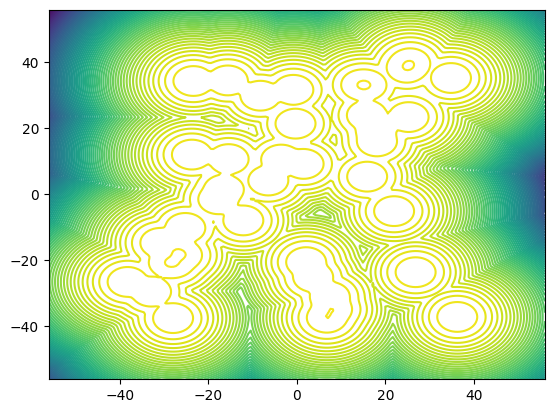

In [2]:
dim = 2
n_mixes = 40
loc_scaling = 40.0  # scale of the problem (changes how far apart the modes of each Guassian component will be)
log_var_scaling = 1.0 # variance of each Gaussian
seed = 0

torch.manual_seed(0)  # seed of 0 for GMM problem
target = GMM(dim=dim, n_mixes=n_mixes,
              loc_scaling=loc_scaling, log_var_scaling=log_var_scaling,
              use_gpu=True, true_expectation_estimation_n_samples=int(1e5))
# plot target
target.to("cpu")
fig, ax = plt.subplots()
plotting_bounds = (-loc_scaling * 1.4, loc_scaling * 1.4)
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=80, ax=ax, grid_width_n_points=200)
target.to("cuda")

In [3]:
# hyper-parameters

# Flow
n_flow_layers = 15
layer_nodes_per_dim = 40
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 128
n_iterations = 4000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 10 # number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0

# AIS
# By default we use a simple metropolis mcmc transition with a fixed step size.
# Can switch this to 'hmc' to improve training efficiency. 
transition_operator_type = "metropolis" 
n_intermediate_distributions = 1
metropolis_step_size = 5.0

# buffer config
n_batches_buffer_sampling = 4
maximum_buffer_length = batch_size * n_batches_buffer_sampling * 100
min_buffer_length = batch_size * n_batches_buffer_sampling * 10

# target p^\alpha q^{a-\alpha} as target for AIS. 
min_is_target = True
p_target = not min_is_target # Whether to use p as the target. 

In [4]:
num_samples = 10000

def plot_dataset(samples):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    target.to("cpu")
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=50, grid_width_n_points=200)
    target.to("cuda")
   
    # plot dataset samples
    plot_marginal_pair(samples, ax=axs[0], bounds=plotting_bounds)
    
    axs[0].set_title("Dataset samples")
    plt.show()
    return [fig]

#plot_dataset(dataset) # Visualise model during initialisation.

In [5]:
import pdb

def normalize(x):
    '''
        normalizes to [-1, 1]
    '''
    #pdb.set_trace()
    mins = torch.min(x, dim=0)[0]
    maxs = torch.max(x, dim=0)[0]
    ## [ 0, 1 ]
    x = (x - mins) / (maxs - mins + 1e-5)
    ## [ -1, 1 ]
    x = x * 2 - 1
    
    #mean = torch.mean(x, dim=0)
    #std = torch.std(x, dim=0)
    #return (x - mean) / std, mean, std, mins, maxs
    return x, mins, maxs

def unnormalize(x, mins, maxs):
    '''
        x : [ 0, 1 ]
    '''
    assert x.max() <= 1 and x.min() >= -1, f'x range: ({x.min():.4f}, {x.max():.4f})'
    #x = x * std + mean
    x = (x + 1) / 2
    return x * (maxs - mins) + mins


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = TMLP(dim = 2).to(device)
model = MyMLP().to(device)


diffusion = GaussianDiffusion(
    model,
    image_size = 2,
    timesteps = 1000    # number of steps
).to(device)

In [7]:
# Training Loop

opt = Adam(diffusion.parameters())
num_train_epochs = 200
dataset = target.sample(torch.tensor(num_samples).unsqueeze(0))
dataset, global_mins, global_maxs = normalize(dataset)
#dataset = torch.tensor(dataset)
train_dataset = TensorDataset(dataset)
train_loader = DataLoader(train_dataset, batch_size = 512, shuffle=True) 

In [8]:
import pdb
for epoch in range(num_train_epochs):
    total_loss = 0.
    print(epoch)
    for i, data in enumerate(train_loader):
        # pdb.set_trace()
        data = data[0].to(device)
        opt.zero_grad()
        loss = diffusion(data)    
        total_loss += loss.item()
        loss.backward()
        opt.step()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [9]:
sampled_points = diffusion.sample(batch_size = 1000)

sampling loop time step: 100%|██████████| 1000/1000 [00:01<00:00, 528.64it/s]


In [10]:
sampled_points.shape

torch.Size([1000, 2])

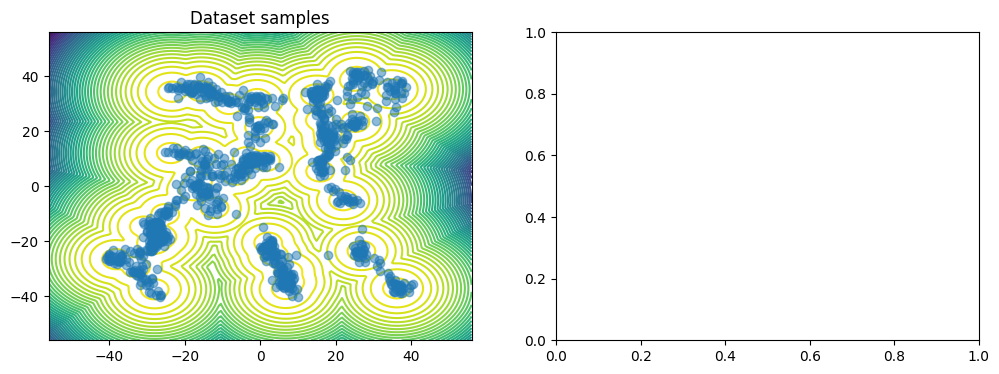

[<Figure size 1200x400 with 2 Axes>]

In [11]:
plot_dataset(unnormalize(sampled_points, global_mins, global_maxs))
#plot_dataset(sampled_points)